<a href="https://colab.research.google.com/github/veda-sunkara/StreetToCloud/blob/master/FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download anything that may need to be downloaded
!pip install rasterio

In [2]:
import os
import random
import numpy as np
from time import time
import matplotlib.pyplot as plt
from comet_ml import Experiment
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as F

from models import get_model
from datasets import get_dataset, get_cs_points_path


In [3]:
# Hyperparameters
MODEL_NAME = 'refiner'  # [unet, refiner, fcn]
DATASET_NAME = 'sen2'  # [sen1, sen2]
CS_POINTS_CLUSTERING = 'high'  # [None, low, high]   OPPOSITE OF DISPERSION!!!
CS_POINTS_NOISE = 'high'  # [None, low, high]
ANNOTATION_LEVEL = 'coarse'  # [coarse, fine]

RUNNAME = '{}_{}_{}_{}_{}'.format(ANNOTATION_LEVEL, MODEL_NAME, DATASET_NAME, 'None' if CS_POINTS_CLUSTERING is None else CS_POINTS_CLUSTERING, 'None' if CS_POINTS_NOISE is None else CS_POINTS_NOISE)

# Training parameters
LR = 1e-4
BATCH_SIZE = 2
EPOCHS = 50

BASE_DIR = '/home/purri/research/water_dots/Sen1_dataset/'  # Need to handle Google Collab directory

experiment = Experiment(api_key="VuSyZ3mBZyDrJ3jkMZuor1YAa",
                        project_name="street2cloud", workspace="matthewpurri")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/matthewpurri/street2cloud/8ba8bb209b9e467483526536af151d66



In [4]:
# set random seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

&lt;torch._C.Generator at 0x7f9650ac4110&gt;

Get CUDA information

In [5]:
device = torch.device('cuda')

Get datasets and create DataLoader objects

In [6]:
# get csv paths
train_data_csv_path = os.path.join(BASE_DIR, 'flood_train_data.csv')
valid_data_csv_path = os.path.join(BASE_DIR, 'flood_valid_data.csv')
test_data_csv_path = os.path.join(BASE_DIR, 'flood_test_data.csv')

crowd_points_path = get_cs_points_path(BASE_DIR, CS_POINTS_CLUSTERING, CS_POINTS_NOISE)

# get dataset objects
train_dataset = get_dataset(DATASET_NAME,
                            BASE_DIR,
                            train_data_csv_path, 
                            crowd_points_path=crowd_points_path,
                            is_train=True,
                            annotation_level=ANNOTATION_LEVEL)
valid_dataset = get_dataset(DATASET_NAME,
                            BASE_DIR,
                            valid_data_csv_path, 
                            crowd_points_path=crowd_points_path,
                            is_train=False,
                            annotation_level=ANNOTATION_LEVEL)
test_dataset = get_dataset(DATASET_NAME,
                           BASE_DIR,
                           test_data_csv_path, 
                           crowd_points_path=crowd_points_path,
                           is_train=False,
                           annotation_level=ANNOTATION_LEVEL)

# create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False,
                             )
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False,
                             )
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=False,
                            )

Load model

In [7]:
net = get_model(MODEL_NAME, DATASET_NAME, crowd_points_path)
net = net.to(device)

Get optimizer, loss scheduler, and loss objective

In [8]:
# optimizer = optim.AdamW(net.parameters(),lr=LR)
optimizer = optim.AdamW(net.parameters(),lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 260, T_mult=2, eta_min=0, last_epoch=-1)
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([1,8], dtype=torch.float).to(device), ignore_index=255, size_average=True)

Metrics

In [9]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)
  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()
  return iou
  

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)

Miscellaneous functions

In [10]:
def ms_to_rgb(ms_img):
    # assume multispectral image is from Sentenal2 satellite
    rgb_img = np.stack((ms_img[3], ms_img[2], ms_img[1])).transpose(1,2,0)
    # normalize to 0-1 range
    n_rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    return n_rgb_img

Create training and evaluate functions

In [11]:
def train_model(model, device, train_loader, loss_func, optimizer, epoch, experiment):
    model.train()
    tbar = tqdm(train_loader)
    total_loss = 0
    train_loss = []
    for batch_idx, batch in enumerate(tbar):
        optimizer.zero_grad()

        data, target = batch['img'], batch['target']
        data, target = data.to(device), target.to(device)

        if crowd_points_path:
            cs_img = batch['cs_img'].to(device)
            output = model([data, cs_img])
        else:
            output = model(data)

        if batch_idx in [0,10,20]:
            fig, ax = plt.subplots(1,3)
            if DATASET_NAME == 'sen2':
                ax[0].imshow(ms_to_rgb(data[0].detach().cpu()))
            elif DATASET_NAME == 'sen1':
                ax[0].imshow(data[0,0,:,:].detach().cpu())
            elif DATASET_NAME == 'syn':
                ax[0].imshow(data[0,0,:,:].detach().cpu())
            ax[0].set_title('RGB')
            ax[1].imshow(target[0,:,:].detach().cpu())
            ax[1].set_title('Mask')
            sm = nn.Softmax(dim=1)
            label_out = torch.argmax(sm(output), dim=1).detach().cpu()[0]
            ax[2].imshow(label_out)
            ax[2].set_title('Prediction')
            experiment.log_figure(figure=fig, figure_name='train_'+str(batch_idx))
            plt.close()

        if MODEL_NAME == 'fcn':
            loss = loss_func(output['out'], target)
        else:
            loss = loss_func(output, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_loss.append(loss.item())
        experiment.log_metric('Train loss:', loss.item())

        tbar.set_description('Train loss: {0:2.4f}'.format(loss.item()))
        
        experiment.log_metric('Train ACC:', computeAccuracy(output, target).item()*100)
        experiment.log_metric('Train mIoU:', computeIOU(output, target).item()*100)

    tbar.set_description('Train loss: {0:2.4f}'.format(total_loss / len(train_loader.dataset)))
    return train_loss

def test_model(model, device, test_loader, loss_func, experiment, eval_name='Valid'):
    model.eval()
    test_loss = 0
    metrics = {'iou': 0,
               'acc': 0,
              }
    with torch.no_grad():
        tbar = tqdm(test_loader)
        for batch_idx, batch in enumerate(tbar):
            data, target = batch['img'], batch['target']
            data, target = data.to(device), target.to(device)

            if crowd_points_path:
                cs_img = batch['cs_img'].to(device)
                output = model([data, cs_img])
            else:
                output = model(data)
            
            if batch_idx in [0, 5]:
                fig, ax = plt.subplots(1,3)
                if DATASET_NAME == 'sen2':
                    ax[0].imshow(ms_to_rgb(data[0].detach().cpu()))
                elif DATASET_NAME == 'sen1':
                    ax[0].imshow(data[0,0,:,:].detach().cpu())
                elif DATASET_NAME == 'syn':
                    ax[0].imshow(data[0,0,:,:].detach().cpu())
                ax[0].set_title('RGB')

                ax[1].imshow(target[0,:,:].detach().cpu())
                ax[1].set_title('Mask')
                sm = nn.Softmax(dim=1)
                label_out = torch.argmax(sm(output), dim=1).detach().cpu()[0]
                ax[2].imshow(label_out)
                ax[2].set_title('Prediction')
                experiment.log_figure(figure=fig, figure_name=eval_name+'_'+str(batch_idx))
                plt.close()


            if MODEL_NAME == 'fcn':
                test_loss += loss_func(output['out'], target).item()
                metrics['iou'] += computeIOU(output['out'], target).item()
                metrics['acc'] += computeAccuracy(output['out'], target).item()
            else:
                iou = computeIOU(output, target).item()
                acc = computeAccuracy(output, target).item()
                test_loss += loss_func(output, target).item()
                metrics['iou'] += iou
                metrics['acc'] += acc

            experiment.log_metric('{} loss:'.format(eval_name), test_loss)
            experiment.log_metric('{} ACC:'.format(eval_name), acc)
            experiment.log_metric('{} mIoU:'.format(eval_name), iou)
 
    test_loss /= len(test_loader.dataset)
    
    # compute average metric
    for metric_name, value in metrics.items():
        metrics[metric_name] = value / len(test_loader)
    
    print('[{0:4d}/{1:4d}]|Acc: {2:3.2f}% |mIoU: {3:3.2f}% |'.format(epoch, EPOCHS, metrics['acc']*100, metrics['iou']*100))
    return metrics

In [12]:
def save_model(model, eval_result, best_result, model_save_path):
    total_result = 0
    for metric, value in eval_result.items():
        # values should have the same range [0,1]
        total_result += value
    
    if total_result > best_result:
        torch.save(model.state_dict(), model_save_path)
        best_result = max(total_result, best_result)
    return best_result
    
def get_save_path(base_dir, runname):
    save_dir = os.path.join('.checkpoints', runname)
    if os.path.isdir(save_dir) is False:
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, 'best_model.pth.tar')
    return save_path

Main training loop

In [13]:
start_time = time()
best_result = 0
model_save_path = get_save_path(BASE_DIR, RUNNAME)
train_loss_vals = []
for epoch in range(1, EPOCHS+1):
    train_loss_vals.extend(train_model(net, device, train_dataloader, loss_func, optimizer, epoch, experiment))
    valid_result = test_model(net, device, valid_dataloader, loss_func, experiment, 'Valid')
    best_result = save_model(net, valid_result, best_result, model_save_path)
    scheduler.step()
print(time() - start_time)


[   1/  50]|Acc: 90.65% |mIoU: 43.43% |



[   2/  50]|Acc: 90.26% |mIoU: 43.48% |



[   3/  50]|Acc: 89.22% |mIoU: 41.03% |



[   4/  50]|Acc: 87.30% |mIoU: 38.40% |



[   5/  50]|Acc: 86.02% |mIoU: 37.86% |



[   6/  50]|Acc: 90.48% |mIoU: 44.07% |



[   7/  50]|Acc: 87.19% |mIoU: 39.84% |



[   8/  50]|Acc: 91.98% |mIoU: 47.27% |



[   9/  50]|Acc: 89.98% |mIoU: 45.43% |



[  10/  50]|Acc: 91.76% |mIoU: 47.73% |



[  11/  50]|Acc: 89.82% |mIoU: 43.88% |



[  12/  50]|Acc: 90.99% |mIoU: 45.82% |



[  13/  50]|Acc: 91.03% |mIoU: 47.36% |



[  14/  50]|Acc: 90.55% |mIoU: 44.49% |



[  15/  50]|Acc: 90.53% |mIoU: 47.34% |



[  16/  50]|Acc: 93.90% |mIoU: 54.20% |



[  17/  50]|Acc: 92.05% |mIoU: 50.54% |



[  18/  50]|Acc: 91.09% |mIoU: 47.52% |



[  19/  50]|Acc: 91.61% |mIoU: 49.97% |



[  20/  50]|Acc: 92.18% |mIoU: 50.37% |



[  21/  50]|Acc: 92.82% |mIoU: 51.30% |



[  22/  50]|Acc: 92.71% |mIoU: 52.50% |



[  23/  50]|Acc: 92.34% |mIoU: 50.17% |



[  24/  50]|Acc: 89.68% |mIoU: 46.29% |



[  25/  50]|Acc: 92.22% |mIoU: 51.09% |



[  26/  50]|Acc: 90.46% |mIoU: 47.28% |



[  27/  50]|Acc: 90.23% |mIoU: 46.44% |



[  28/  50]|Acc: 93.01% |mIoU: 54.70% |



[  29/  50]|Acc: 92.60% |mIoU: 50.67% |



[  30/  50]|Acc: 90.74% |mIoU: 47.83% |



[  31/  50]|Acc: 93.07% |mIoU: 53.44% |



[  32/  50]|Acc: 91.62% |mIoU: 47.84% |



[  33/  50]|Acc: 89.94% |mIoU: 46.19% |



[  34/  50]|Acc: 93.02% |mIoU: 55.33% |



[  35/  50]|Acc: 93.60% |mIoU: 54.32% |



[  36/  50]|Acc: 91.90% |mIoU: 53.78% |



[  37/  50]|Acc: 92.27% |mIoU: 51.83% |



[  38/  50]|Acc: 94.05% |mIoU: 58.66% |



[  39/  50]|Acc: 92.99% |mIoU: 53.43% |



[  40/  50]|Acc: 93.07% |mIoU: 53.40% |



[  41/  50]|Acc: 95.38% |mIoU: 62.01% |



[  42/  50]|Acc: 88.50% |mIoU: 43.13% |



[  43/  50]|Acc: 92.94% |mIoU: 53.39% |



[  44/  50]|Acc: 93.93% |mIoU: 55.46% |



[  45/  50]|Acc: 94.90% |mIoU: 61.58% |



[  46/  50]|Acc: 94.75% |mIoU: 60.93% |



[  47/  50]|Acc: 96.08% |mIoU: 64.27% |



[  48/  50]|Acc: 93.56% |mIoU: 56.64% |



[  49/  50]|Acc: 96.34% |mIoU: 65.36% |



[  50/  50]|Acc: 95.80% |mIoU: 63.53% |
2401.502779483795


Evaluate model

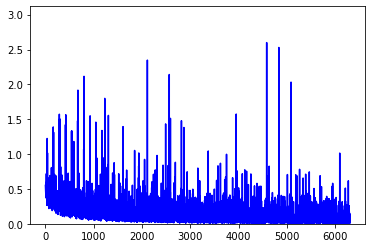

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(train_loss_vals, 'b-')
plt.ylim([0, max(train_loss_vals)*1.2])
plt.show()

In [15]:
# paper had result of 40.84 mIoU
eval_result = test_model(net, device, test_dataloader, loss_func, experiment, eval_name='Test')


[  50/  50]|Acc: 96.99% |mIoU: 54.73% |
